# 1. Importing Libraries and Datas

In [1]:
#importing libraries
import pandas as pd
import numpy as np

# Loading datasets
calls_df = pd.read_csv('calls.csv')
customers_df = pd.read_csv('customers.csv')
reasons_df = pd.read_csv('reason.csv')
sentiment_stats_df = pd.read_csv('sentiment_statistics.csv')

In [2]:
# Displaying few rows to check data
print(calls_df.head())
print(customers_df.head())
print(reasons_df.head())
print(sentiment_stats_df.head())

# Drop rows with null values in all provided dataframes
# For calls dataframe
calls_df = calls_df.dropna()

# For reasons dataframe
reasons_df = reasons_df.dropna()

# For sentiment statistics dataframe
sentiment_stats_df = sentiment_stats_df.dropna()


      call_id  customer_id  agent_id call_start_datetime  \
0  4667960400   2033123310    963118     7/31/2024 23:56   
1  1122072124   8186702651    519057       8/1/2024 0:03   
2  6834291559   2416856629    158319     7/31/2024 23:59   
3  2266439882   1154544516    488324       8/1/2024 0:05   
4  1211603231   5214456437    721730       8/1/2024 0:04   

  agent_assigned_datetime call_end_datetime  \
0           8/1/2024 0:03     8/1/2024 0:34   
1           8/1/2024 0:06     8/1/2024 0:18   
2           8/1/2024 0:07     8/1/2024 0:26   
3           8/1/2024 0:10     8/1/2024 0:17   
4           8/1/2024 0:14     8/1/2024 0:23   

                                     call_transcript  
0  \n\nAgent: Thank you for calling United Airlin...  
1  \n\nAgent: Thank you for calling United Airlin...  
2  \n\nAgent: Thank you for calling United Airlin...  
3  \n\nAgent: Thank you for calling United Airlin...  
4  \n\nAgent: Thank you for calling United Airlin...  
   customer_id      custom

## Cleaning file that contain reasons

In [3]:
import pandas as pd
import re

# Function to clean spaces
def clean_spaces(text):
    if isinstance(text, str):
        # Remove leading and trailing spaces
        text = text.strip()
        # Replace multiple spaces with a single space
        text = re.sub(r'\s+', ' ', text)
    return text

#cleaning function to the primary_call_reason column
reasons_df['primary_call_reason'] = reasons_df['primary_call_reason'].apply(clean_spaces)


In [4]:
# Mapping dictionary for similar phrases
mapping = {
    'Post Flight': 'Post-Flight',
    'Products & Services': 'Products and Services',
    'Check In': 'Check-In'
}

# Replace similar reasons using the mapping
reasons_df['primary_call_reason'] = reasons_df['primary_call_reason'].replace(mapping)

# Display the cleaned reasons
print("Cleaned Primary Call Reasons:")
print(reasons_df)


Cleaned Primary Call Reasons:
          call_id primary_call_reason
0      4667960400    Voluntary Cancel
1      1122072124             Booking
2      6834291559              IRROPS
3      2266439882             Upgrade
4      1211603231             Seating
...           ...                 ...
66648  7569738090        Mileage Plus
66649  1563273072         Post-Flight
66650  8865997781             Upgrade
66651  8019240181             Upgrade
66652  8210720833     Digital Support

[66653 rows x 2 columns]


# 2. Calculating AHT and AST

In [5]:
# Convert the datetime columns to the proper format
calls_df['call_start_datetime'] = pd.to_datetime(calls_df['call_start_datetime'])
calls_df['agent_assigned_datetime'] = pd.to_datetime(calls_df['agent_assigned_datetime'])
calls_df['call_end_datetime'] = pd.to_datetime(calls_df['call_end_datetime'])

# Calculate Handle Time for each call (in seconds)
calls_df['handle_time'] = (calls_df['call_end_datetime'] - calls_df['agent_assigned_datetime']).dt.total_seconds()

# AHT = Total Handle Time / Total Number of Calls
AHT = calls_df['handle_time'].mean()
print(f'Average Handle Time (AHT): {AHT} seconds')

# Calculate Speed to Answer (in seconds)
calls_df['speed_to_answer'] = (calls_df['agent_assigned_datetime'] - calls_df['call_start_datetime']).dt.total_seconds()

# AST = Total Waiting Time / Total Number of Calls
AST = calls_df['speed_to_answer'].mean()
print(f'Average Speed to Answer (AST): {AST} seconds')


Average Handle Time (AHT): 697.0486004734717 seconds
Average Speed to Answer (AST): 437.0675393399248 seconds


#Step 3: Analyzing Factors Affecting AHT/AST

#### By Call Reason:

In [6]:
# Merge calls data with reasons
call_reasons = pd.merge(calls_df, reasons_df, on='call_id', how='left')

# Calculate AHT and AST by primary call reason
aht_by_reason = call_reasons.groupby('primary_call_reason').agg({'handle_time': 'mean', 'speed_to_answer': 'mean'}).reset_index()

# Sort by AHT to find reasons causing long handle times
aht_by_reason.sort_values(by='handle_time', ascending=False, inplace=True)
print(aht_by_reason.head())


   primary_call_reason  handle_time  speed_to_answer
3             Checkout  1016.853814       724.703390
9         Mileage Plus   995.573406       361.015211
7                  ETC   962.899160       544.285714
11         Post-Flight   932.896074       569.431871
4       Communications   826.718750       239.968750


#### By Customer Loyalty:

In [7]:
# Merge calls data with customers to get loyalty status
call_customers = pd.merge(calls_df, customers_df, on='customer_id', how='left')

# Calculate AHT and AST by customer loyalty status (mp_status), including NaN values
aht_by_loyalty = call_customers.groupby('elite_level_code', dropna=False).agg({'handle_time': 'mean', 'speed_to_answer': 'mean'}).reset_index()

# Display the result
print(aht_by_loyalty)


   elite_level_code  handle_time  speed_to_answer
0               0.0   695.999166       438.579273
1               1.0   688.371608       436.918580
2               2.0   726.449925       432.772795
3               3.0   727.510460       429.341004
4               4.0   788.244706       413.308235
5               5.0   896.950608       411.410165
6               NaN   668.173245       442.715101


## Analysing AHT with Parameters

In [8]:
# Convert datetime columns
calls_df['call_start_datetime'] = pd.to_datetime(calls_df['call_start_datetime'])
calls_df['agent_assigned_datetime'] = pd.to_datetime(calls_df['agent_assigned_datetime'])
calls_df['call_end_datetime'] = pd.to_datetime(calls_df['call_end_datetime'])

# Calculate handle time and speed to answer
calls_df['handle_time'] = (calls_df['call_end_datetime'] - calls_df['agent_assigned_datetime']).dt.total_seconds()
calls_df['speed_to_answer'] = (calls_df['agent_assigned_datetime'] - calls_df['call_start_datetime']).dt.total_seconds()

# Identify High-Volume Call Periods
calls_df['call_hour'] = calls_df['call_start_datetime'].dt.hour
high_volume_periods = calls_df.groupby('call_hour').size().reset_index(name='call_count')
high_volume_threshold = high_volume_periods['call_count'].quantile(0.75)  # Top 25% as high volume
high_volume_hours = high_volume_periods[high_volume_periods['call_count'] >= high_volume_threshold]['call_hour']


In [9]:
# Analyze AHT and AST during high-volume periods
high_volume_calls = calls_df[calls_df['call_hour'].isin(high_volume_hours)]

# 1. AHT and AST during high-volume periods
high_volume_aht = high_volume_calls['handle_time'].mean()
high_volume_ast = high_volume_calls['speed_to_answer'].mean()

# Print results for high-volume periods
print(f"Average Handle Time (AHT) during high-volume periods: {high_volume_aht:.2f} seconds")
print(f"Average Speed to Answer (AST) during high-volume periods: {high_volume_ast:.2f} seconds")

# 2. Analyze AHT and AST by call reason during high-volume periods
call_reasons = pd.merge(high_volume_calls, reasons_df, on='call_id', how='left')
aht_by_reason_high_volume = call_reasons.groupby('primary_call_reason')['handle_time'].mean().reset_index()

# Sort by AHT to find reasons causing long handle times
aht_by_reason_high_volume.sort_values(by='handle_time', ascending=False, inplace=True)
print("AHT by Primary Call Reason during High-Volume Periods:")
print(aht_by_reason_high_volume)

# 3. Analyze AHT and AST by customer loyalty status (if available)
if 'customer_id' in calls_df.columns and 'elite_level_code' in customers_df.columns:
    call_customers = pd.merge(high_volume_calls, customers_df, on='customer_id', how='left')
    aht_by_loyalty = call_customers.groupby('elite_level_code').agg({'handle_time': 'mean', 'speed_to_answer': 'mean'}).reset_index()
    print("AHT and AST by Customer Loyalty Status during High-Volume Periods:")
    print(aht_by_loyalty)

# 4. Analyze AHT and AST by agent (if agent data is available)
if 'agent_id' in calls_df.columns:
    aht_by_agent = high_volume_calls.groupby('agent_id').agg({'handle_time': 'mean', 'speed_to_answer': 'mean'}).reset_index()
    aht_by_agent.sort_values(by='handle_time', ascending=False, inplace=True)
    print("AHT and AST by Agent during High-Volume Periods:")
    print(aht_by_agent)

# 5. Identify any trends over time
# Optional: analyze trends over weeks or months if timestamps are available
calls_df['call_week'] = calls_df['call_start_datetime'].dt.isocalendar().week
trends_aht = calls_df.groupby('call_week')['handle_time'].mean().reset_index()
print("AHT Trends Over Weeks:")
print(trends_aht)


Average Handle Time (AHT) during high-volume periods: 693.94 seconds
Average Speed to Answer (AST) during high-volume periods: 437.37 seconds
AHT by Primary Call Reason during High-Volume Periods:
      primary_call_reason  handle_time
3                Checkout  1031.654135
9            Mileage Plus  1000.787037
11            Post-Flight   913.343558
7                     ETC   874.328358
4          Communications   835.331307
8                  IRROPS   783.045478
12  Products and Services   745.481682
18       Voluntary Cancel   725.416667
19       Voluntary Change   644.199288
17                Upgrade   620.016639
2                Check-In   561.357143
16    Unaccompanied Minor   476.326531
14                Seating   474.506128
13        Schedule Change   459.578313
1                 Booking   413.689840
15       Traveler Updates   389.927007
10           Other Topics   366.591549
5         Digital Support   363.978495
0                 Baggage   331.653160
6              Disabili

### Percentage difference of AHT between most frequent and least frequent call reasons

In [10]:
# Group the data by call reasons and calculate the count of each reason
reason_counts = call_reasons['primary_call_reason'].value_counts()

# Identify the most frequent and least frequent call reasons
most_frequent_reason = reason_counts.idxmax()
least_frequent_reason = reason_counts.idxmin()

# Calculate AHT for the most frequent call reason
aht_most_frequent = call_reasons[call_reasons['primary_call_reason'] == most_frequent_reason]['handle_time'].mean()

# Calculate AHT for the least frequent call reason
aht_least_frequent = call_reasons[call_reasons['primary_call_reason'] == least_frequent_reason]['handle_time'].mean()

# Calculate percentage difference between AHT for most and least frequent reasons
percentage_difference = ((aht_most_frequent - aht_least_frequent) / aht_least_frequent) * 100

# Print results
print(f"Most frequent call reason: {most_frequent_reason}, AHT: {aht_most_frequent} seconds")
print(f"Least frequent call reason: {least_frequent_reason}, AHT: {aht_least_frequent} seconds")
print(f"Percentage difference in AHT between most and least frequent call reasons: {percentage_difference:.2f}%")


Most frequent call reason: IRROPS, AHT: 783.0454777721002 seconds
Least frequent call reason: Unaccompanied Minor, AHT: 476.3265306122449 seconds
Percentage difference in AHT between most and least frequent call reasons: 64.39%


## ANALYSIS

In [11]:
# Merge high volume calls with sentiment statistics
high_volume_sentiment = pd.merge(high_volume_calls, sentiment_stats_df, on='call_id', how='left')

# Display the merged DataFrame to check sentiment data
print(high_volume_sentiment.head())

# Calculate AHT and AST by average sentiment
aht_by_sentiment = high_volume_sentiment.groupby('average_sentiment').agg({
    'handle_time': 'mean',
    'speed_to_answer': 'mean'
}).reset_index()

print("AHT and AST by Average Sentiment during High-Volume Periods:")
print(aht_by_sentiment)

# Analyze AHT and AST by agent tone
aht_by_agent_tone = high_volume_sentiment.groupby('agent_tone').agg({
    'handle_time': 'mean',
    'speed_to_answer': 'mean'
}).reset_index()

print("AHT and AST by Agent Tone during High-Volume Periods:")
print(aht_by_agent_tone)

# Analyze AHT and AST by customer tone
aht_by_customer_tone = high_volume_sentiment.groupby('customer_tone').agg({
    'handle_time': 'mean',
    'speed_to_answer': 'mean'
}).reset_index()

print("AHT and AST by Customer Tone during High-Volume Periods:")
print(aht_by_customer_tone)


# Analyze AHT and AST by silence percentage
aht_by_silence = high_volume_sentiment.groupby('silence_percent_average').agg({
    'handle_time': 'mean',
    'speed_to_answer': 'mean'
}).reset_index()

print("AHT and AST by Silence Percentage during High-Volume Periods:")
print(aht_by_silence)



      call_id  customer_id  agent_id_x call_start_datetime  \
0  4593315374   1448092013      915618 2024-08-01 09:01:00   
1  2637809196   2139034674      825827 2024-08-01 09:02:00   
2  6655849241   2971678936      215457 2024-08-01 09:03:00   
3  5401438897   6942343286      274746 2024-08-01 09:00:00   
4  9388435740   8198242256      828869 2024-08-01 09:01:00   

  agent_assigned_datetime   call_end_datetime  \
0     2024-08-01 09:05:00 2024-08-01 09:16:00   
1     2024-08-01 09:06:00 2024-08-01 09:10:00   
2     2024-08-01 09:07:00 2024-08-01 09:17:00   
3     2024-08-01 09:09:00 2024-08-01 09:41:00   
4     2024-08-01 09:10:00 2024-08-01 09:19:00   

                                     call_transcript  handle_time  \
0  \n\nAgent: Thank you for calling United Airlin...        660.0   
1  \n\nAgent: Thank you for calling United Airlin...        240.0   
2  \n\nAgent: Thank you for calling United Airlin...        600.0   
3  \n\nAgent: Thank you for calling United Airlin...    

#Visualization

### Comparing AHT and AST by Agent Tone

/var/folders/nq/999184vs10z8d59n1_268m_c0000gn/T/ipykernel_30734/3803792047.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='agent_tone', y='AHT', data=aht_by_agent_tone, palette='Reds')


([0, 1, 2, 3, 4],
 [Text(0, 0, 'angry'),
  Text(1, 0, 'calm'),
  Text(2, 0, 'frustrated'),
  Text(3, 0, 'neutral'),
  Text(4, 0, 'polite')])

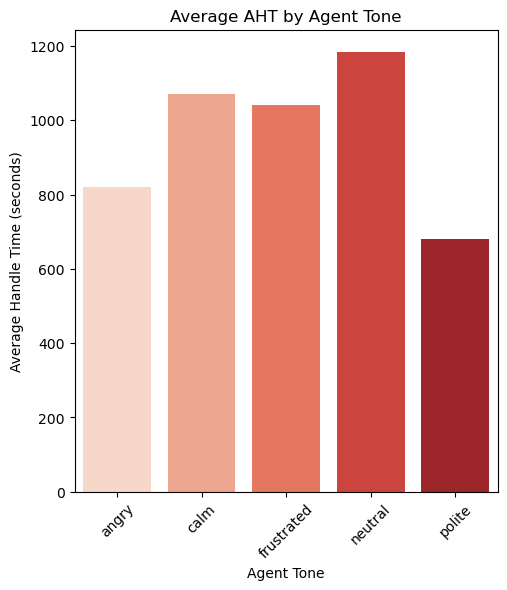

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Merge the calls DataFrame with sentiment_stats
merged_df = pd.merge(calls_df, sentiment_stats_df, on='call_id')

# Calculate AHT and AST
merged_df['AHT'] = merged_df['call_end_datetime'] - merged_df['call_start_datetime']
merged_df['AST'] = merged_df['agent_assigned_datetime'] - merged_df['call_start_datetime']
merged_df['AHT'] = merged_df['AHT'].dt.total_seconds()
merged_df['AST'] = merged_df['AST'].dt.total_seconds()

# Set the figure size
plt.figure(figsize=(12, 6))

# Subplot 1: Average AHT by Agent Tone
plt.subplot(1, 2, 1)
aht_by_agent_tone = merged_df.groupby('agent_tone')['AHT'].mean().reset_index()
sns.barplot(x='agent_tone', y='AHT', data=aht_by_agent_tone, palette='Reds')
plt.title('Average AHT by Agent Tone')
plt.xlabel('Agent Tone')
plt.ylabel('Average Handle Time (seconds)')
plt.xticks(rotation=45)




/var/folders/nq/999184vs10z8d59n1_268m_c0000gn/T/ipykernel_30734/2586625862.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='agent_tone', y='AST', data=ast_by_agent_tone, palette='Blues')


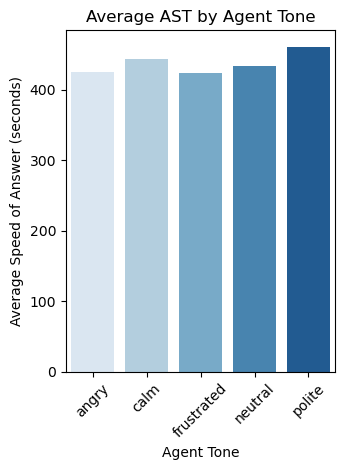

In [13]:
# Subplot 2: Average AST by Agent Tone
plt.subplot(1, 2, 2)
ast_by_agent_tone = merged_df.groupby('agent_tone')['AST'].mean().reset_index()
sns.barplot(x='agent_tone', y='AST', data=ast_by_agent_tone, palette='Blues')
plt.title('Average AST by Agent Tone')
plt.xlabel('Agent Tone')
plt.ylabel('Average Speed of Answer (seconds)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Snippet 2: Comparing AHT and AST by Customer Tone**


/var/folders/nq/999184vs10z8d59n1_268m_c0000gn/T/ipykernel_30734/2757561670.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='customer_tone', y='AHT', data=aht_by_customer_tone, palette='Greens')


([0, 1, 2, 3, 4],
 [Text(0, 0, 'angry'),
  Text(1, 0, 'calm'),
  Text(2, 0, 'frustrated'),
  Text(3, 0, 'neutral'),
  Text(4, 0, 'polite')])

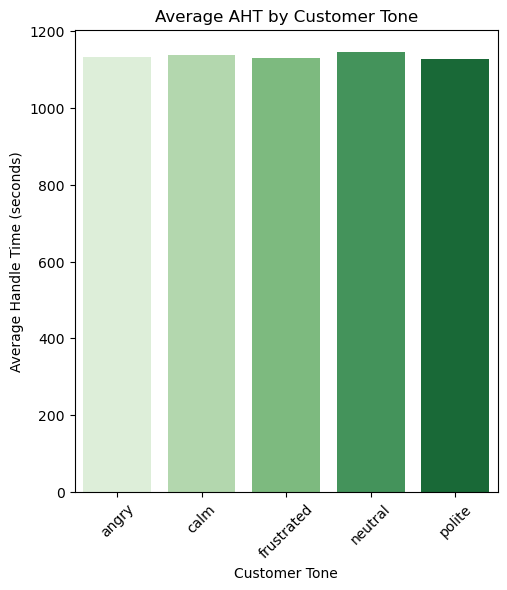

In [14]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Subplot 1: Average AHT by Customer Tone
plt.subplot(1, 2, 1)
aht_by_customer_tone = merged_df.groupby('customer_tone')['AHT'].mean().reset_index()
sns.barplot(x='customer_tone', y='AHT', data=aht_by_customer_tone, palette='Greens')
plt.title('Average AHT by Customer Tone')
plt.xlabel('Customer Tone')
plt.ylabel('Average Handle Time (seconds)')
plt.xticks(rotation=45)



/var/folders/nq/999184vs10z8d59n1_268m_c0000gn/T/ipykernel_30734/2835650380.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='customer_tone', y='AST', data=ast_by_customer_tone, palette='Blues')


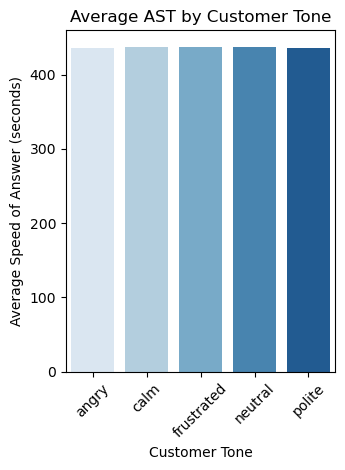

In [15]:
# Subplot 2: Average AST by Customer Tone
plt.subplot(1, 2, 2)
ast_by_customer_tone = merged_df.groupby('customer_tone')['AST'].mean().reset_index()
sns.barplot(x='customer_tone', y='AST', data=ast_by_customer_tone, palette='Blues')
plt.title('Average AST by Customer Tone')
plt.xlabel('Customer Tone')
plt.ylabel('Average Speed of Answer (seconds)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# Code for AHT by primary_call_reason


/var/folders/nq/999184vs10z8d59n1_268m_c0000gn/T/ipykernel_30734/3941606082.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AHT', y='primary_call_reason', data=aht_by_call_reason, palette='Oranges_d')


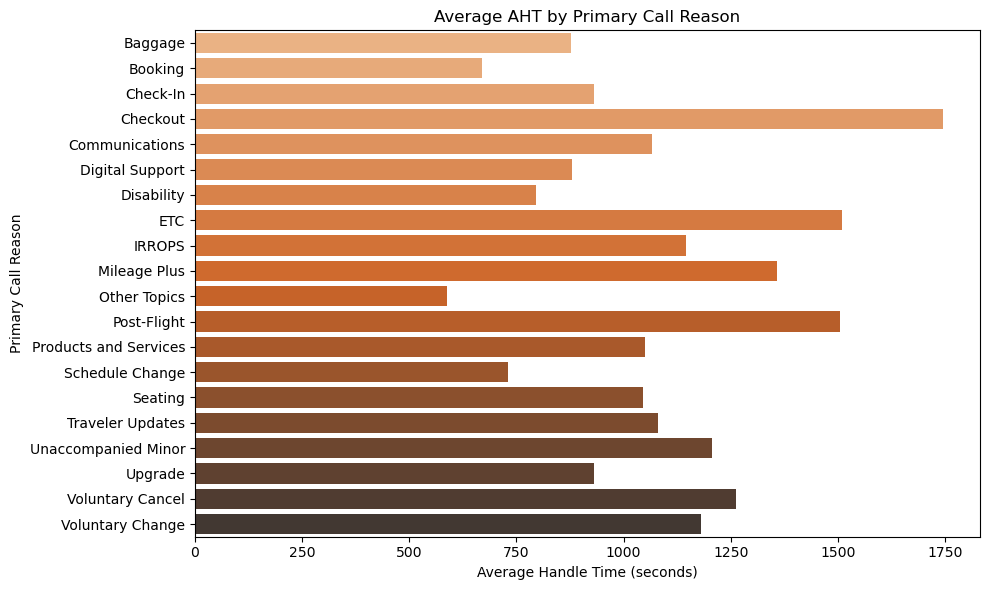

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'calls' and 'sentiment_stats' are already merged into 'merged_df'
# Now, merge 'reasons' DataFrame to add primary_call_reason
merged_df_with_reasons = pd.merge(merged_df, reasons_df, on='call_id')

# Calculate AHT (if not already calculated)
merged_df_with_reasons['AHT'] = merged_df_with_reasons['call_end_datetime'] - merged_df_with_reasons['call_start_datetime']
merged_df_with_reasons['AHT'] = merged_df_with_reasons['AHT'].dt.total_seconds()

# Calculate AST (if not already calculated)
merged_df_with_reasons['AST'] = merged_df_with_reasons['agent_assigned_datetime'] - merged_df_with_reasons['call_start_datetime']
merged_df_with_reasons['AST'] = merged_df_with_reasons['AST'].dt.total_seconds()

# Group by primary_call_reason and calculate the average AHT
aht_by_call_reason = merged_df_with_reasons.groupby('primary_call_reason')['AHT'].mean().reset_index()

# Plot the Average AHT by Primary Call Reason
plt.figure(figsize=(10, 6))
sns.barplot(x='AHT', y='primary_call_reason', data=aht_by_call_reason, palette='Oranges_d')
plt.title('Average AHT by Primary Call Reason')
plt.xlabel('Average Handle Time (seconds)')
plt.ylabel('Primary Call Reason')
plt.tight_layout()
plt.show()



Code Snippet for AST by primary_call_reason:


/var/folders/nq/999184vs10z8d59n1_268m_c0000gn/T/ipykernel_30734/3393252212.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AST', y='primary_call_reason', data=ast_by_call_reason, palette='Purples_d')


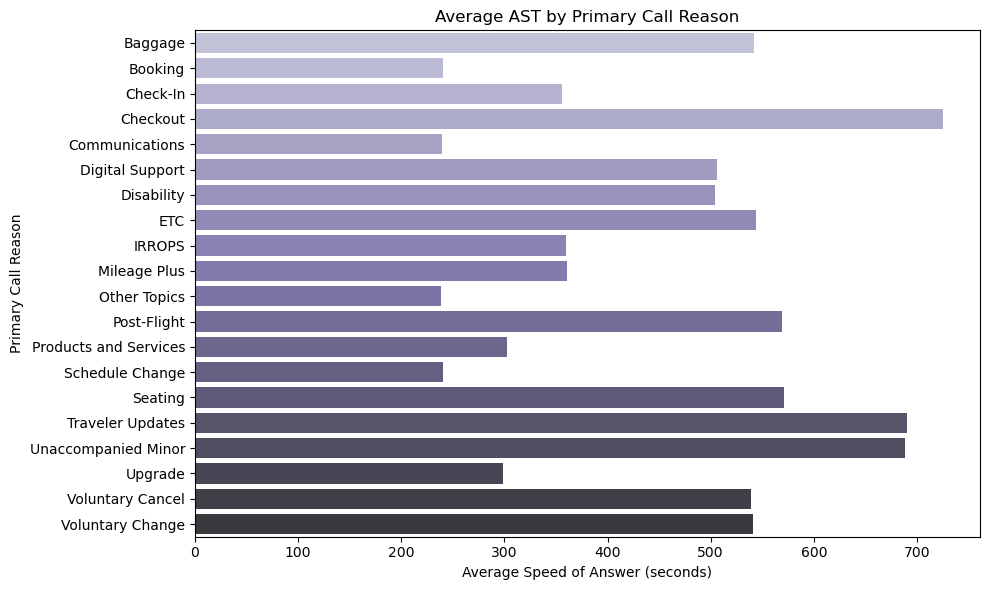

In [17]:
# Group by primary_call_reason and calculate the average AST
ast_by_call_reason = merged_df_with_reasons.groupby('primary_call_reason')['AST'].mean().reset_index()

# Plot the Average AST by Primary Call Reason
plt.figure(figsize=(10, 6))
sns.barplot(x='AST', y='primary_call_reason', data=ast_by_call_reason, palette='Purples_d')
plt.title('Average AST by Primary Call Reason')
plt.xlabel('Average Speed of Answer (seconds)')
plt.ylabel('Primary Call Reason')
plt.tight_layout()
plt.show()


**Code Snippet for AHT and AST by Customer Loyalty Status**

/var/folders/nq/999184vs10z8d59n1_268m_c0000gn/T/ipykernel_30734/131657021.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='elite_level_code', y='handle_time', data=aht_by_loyalty, palette='Blues_d')


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, '0.0'),
  Text(1, 0, '1.0'),
  Text(2, 0, '2.0'),
  Text(3, 0, '3.0'),
  Text(4, 0, '4.0'),
  Text(5, 0, '5.0')])

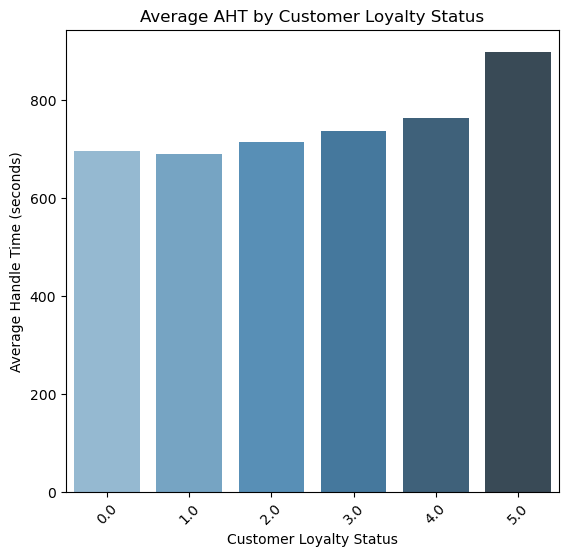

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with subplots
plt.figure(figsize=(14, 6))

# Subplot 1: Average AHT by Customer Loyalty Status
plt.subplot(1, 2, 1)
sns.barplot(x='elite_level_code', y='handle_time', data=aht_by_loyalty, palette='Blues_d')
plt.title('Average AHT by Customer Loyalty Status')
plt.xlabel('Customer Loyalty Status')
plt.ylabel('Average Handle Time (seconds)')
plt.xticks(rotation=45)



/var/folders/nq/999184vs10z8d59n1_268m_c0000gn/T/ipykernel_30734/2661688952.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='elite_level_code', y='speed_to_answer', data=aht_by_loyalty, palette='Greens_d')


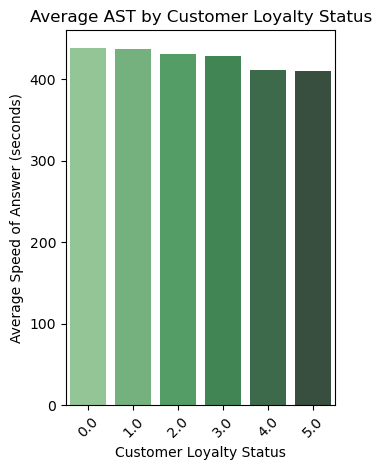

In [19]:
# Subplot 2: Average AST by Customer Loyalty Status
plt.subplot(1, 2, 2)
sns.barplot(x='elite_level_code', y='speed_to_answer', data=aht_by_loyalty, palette='Greens_d')
plt.title('Average AST by Customer Loyalty Status')
plt.xlabel('Customer Loyalty Status')
plt.ylabel('Average Speed of Answer (seconds)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# IVR IMPROVEMENTS ANALYSIS

In [20]:
# Import necessary libraries
from collections import Counter
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud


In [21]:
# Step 1: Define Full Stop Words
stop_words = set([
    'to', 'the', 'you', 'i', 'for', 'a', 'and', 'is', 'on',
    'it', 'have', 'that', 'can', 'let', 'me', 'of', 'at',
    'this', 'my', 'but', 'are', 'be', 'was', 'we', 'as',
    'not', 'if', 'which', 'an', 'your', 'all', 'so',
    'about', 'out', 'get', 'there', 'just', 'no', 'like',
    'do', 'what', 'when', 'where', 'who', 'more', 'than',
    'other', 'these', 'their', 'its', 'then', 'that',
    'up', 'now', 'over', 'by', 'some', 'time', 'how', 'would',
    'any', 'from', 'yeah', 'im', 'youre', 'please', 'today',
    'could', 'see', 'does', 'will', 'am', 'been', 'much', 'got',
    'since', 'may', 'hi', 'ill', 'umm'
])

In [22]:
# Step 2: Function to Clean and Tokenize Text
def clean_and_tokenize(transcript):
    """
    Cleans the transcript by removing special characters and stopwords,
    then tokenizes the text into words.
    """
    # Remove special characters and convert to lowercase
    cleaned = re.sub(r'[^a-zA-Z\s]', '', transcript.lower())
    tokens = cleaned.split()
    # Remove stopwords
    return [word for word in tokens if word not in stop_words]



In [23]:
# Merge calls with reasons on 'call_id'
merged_df = pd.merge(calls_df, reasons_df, on='call_id', how='left')

In [24]:
# Verify that 'primary_call_reason' exists after merge
if 'primary_call_reason' not in merged_df.columns:
    raise KeyError("The column 'primary_call_reason' was not found in the merged dataframe. Please check your data.")


In [25]:
# Step 4: Extract and Count Unigrams, Bigrams, Trigrams
# Initialize Counters
word_counts = Counter()
bigrams = Counter()
trigrams = Counter()

# Iterate through each transcript to populate the Counters
for transcript in merged_df['call_transcript']:
    tokens = clean_and_tokenize(transcript)
    word_counts.update(tokens)
    bigrams.update(zip(tokens[:-1], tokens[1:]))
    trigrams.update(zip(tokens[:-2], tokens[1:-1], tokens[2:]))

In [26]:
# Step 5: Display Most Common Unigrams, Bigrams, Trigrams
print("Most Common Words in Call Transcripts:")
print(word_counts.most_common(100))

print("\nMost Common Bigrams in Call Transcripts:")
print(bigrams.most_common(20))

print("\nMost Common Trigrams in Call Transcripts:")
print(trigrams.most_common(20))

Most Common Words in Call Transcripts:
[('flight', 629840), ('agent', 554444), ('customer', 545645), ('change', 245471), ('with', 227342), ('help', 200997), ('in', 200328), ('thank', 184714), ('united', 172005), ('calling', 159962), ('typing', 145719), ('next', 142014), ('okay', 138283), ('work', 134041), ('day', 132451), ('take', 131403), ('need', 126264), ('really', 119975), ('thanks', 119487), ('know', 118799), ('chicago', 115015), ('one', 114165), ('call', 113217), ('looks', 112484), ('look', 106962), ('fee', 97703), ('reservation', 97645), ('make', 96256), ('or', 94900), ('travel', 94347), ('good', 93838), ('booked', 92608), ('pm', 91834), ('new', 90384), ('name', 89990), ('airlines', 89223), ('anything', 86991), ('check', 85309), ('understand', 83499), ('problem', 80119), ('go', 79390), ('rest', 77917), ('better', 76209), ('well', 75848), ('too', 74873), ('confirmation', 74367), ('ahead', 74054), ('welcome', 73436), ('number', 72599), ('very', 71821), ('pull', 70535), ('ive', 667

In [27]:

# Step 6: Visualization Functions
def plot_word_frequencies(counter, title, top_n=20):
    """
    Plots the top_n most common words or phrases from a Counter.
    """
    phrases, counts = zip(*counter.most_common(top_n))
    # Convert tuples to strings for bigrams and trigrams
    phrases = [' '.join(phrase) if isinstance(phrase, tuple) else phrase for phrase in phrases]

    plt.figure(figsize=(12, 8))
    plt.bar(phrases, counts, color='Green')
    plt.xticks(rotation=45, ha='right')
    plt.title(title, fontsize=16)
    plt.xlabel('Phrases', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.tight_layout()
    plt.show()

In [28]:
def generate_wordcloud(counter, title):
    """
    Generates and displays a word cloud from a Counter.
    """
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(counter)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

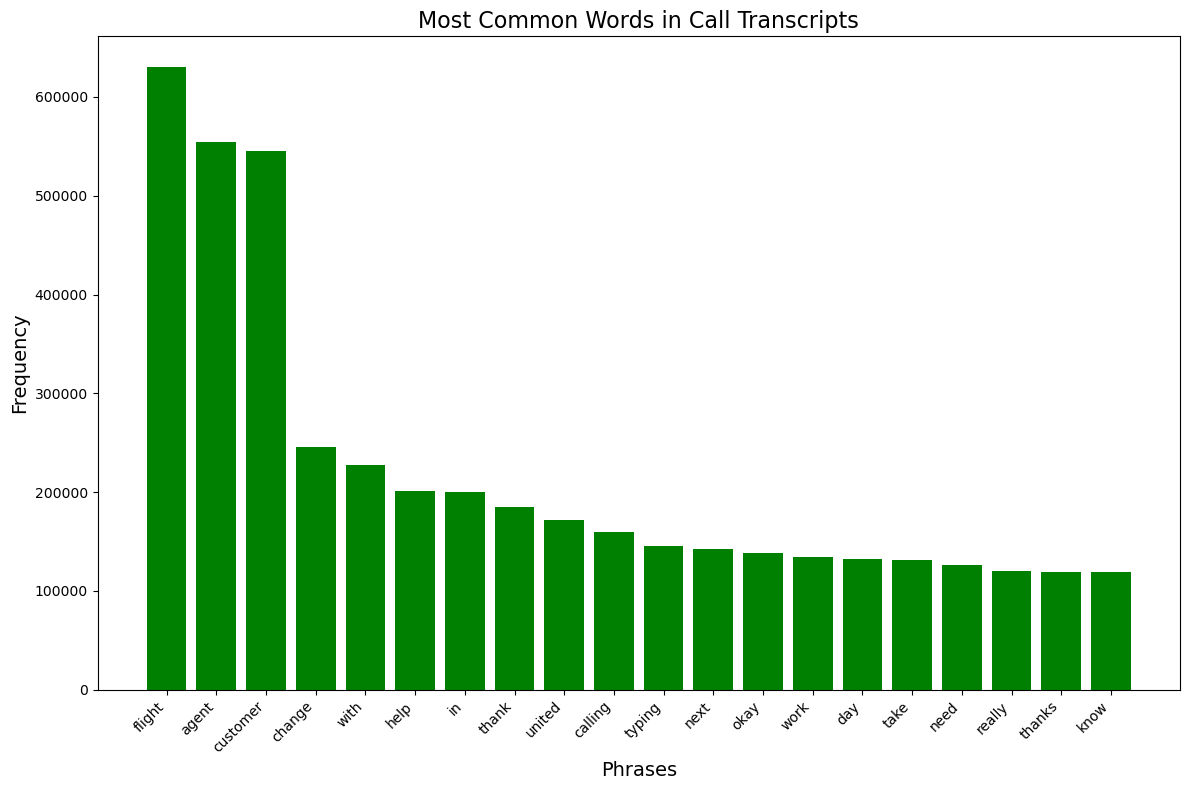

In [29]:
# Step 7: Plot Most Common Unigrams, Bigrams, Trigrams
plot_word_frequencies(word_counts, "Most Common Words in Call Transcripts")

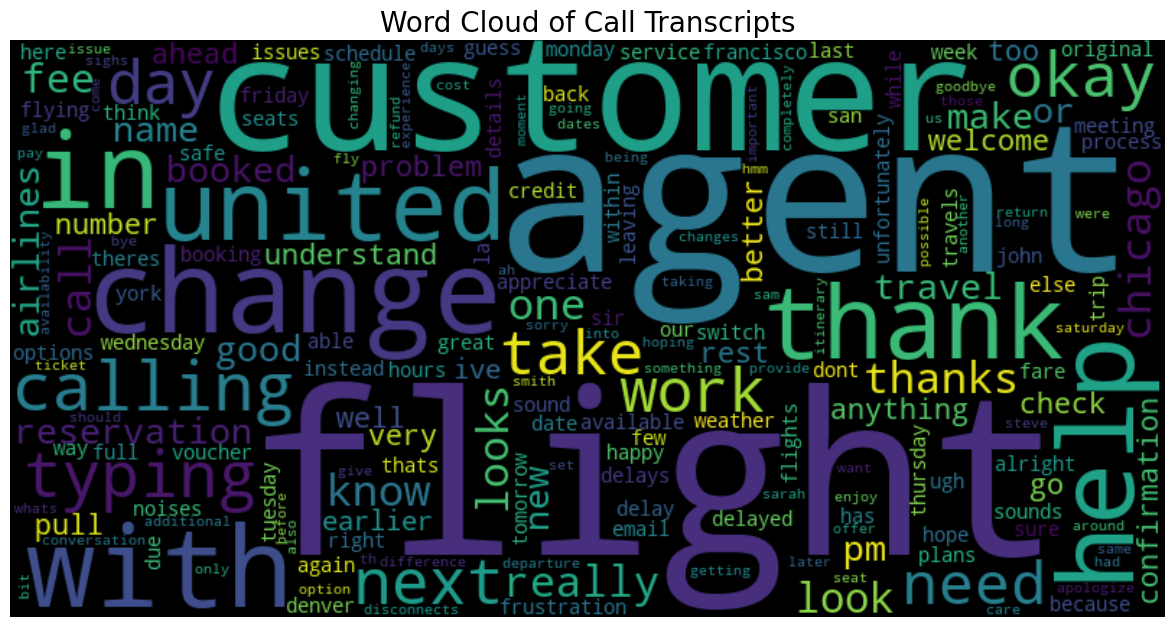

In [30]:
generate_wordcloud(word_counts, "Word Cloud of Call Transcripts")

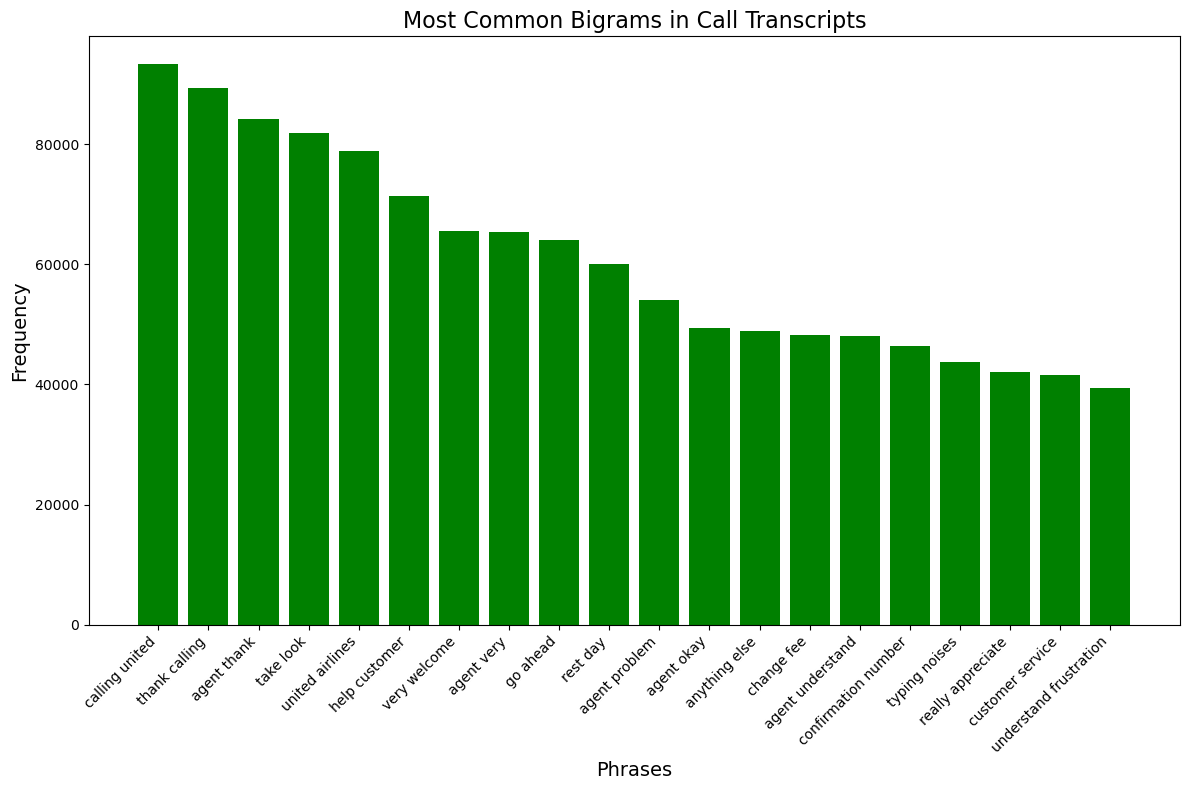

In [31]:
plot_word_frequencies(bigrams, "Most Common Bigrams in Call Transcripts")

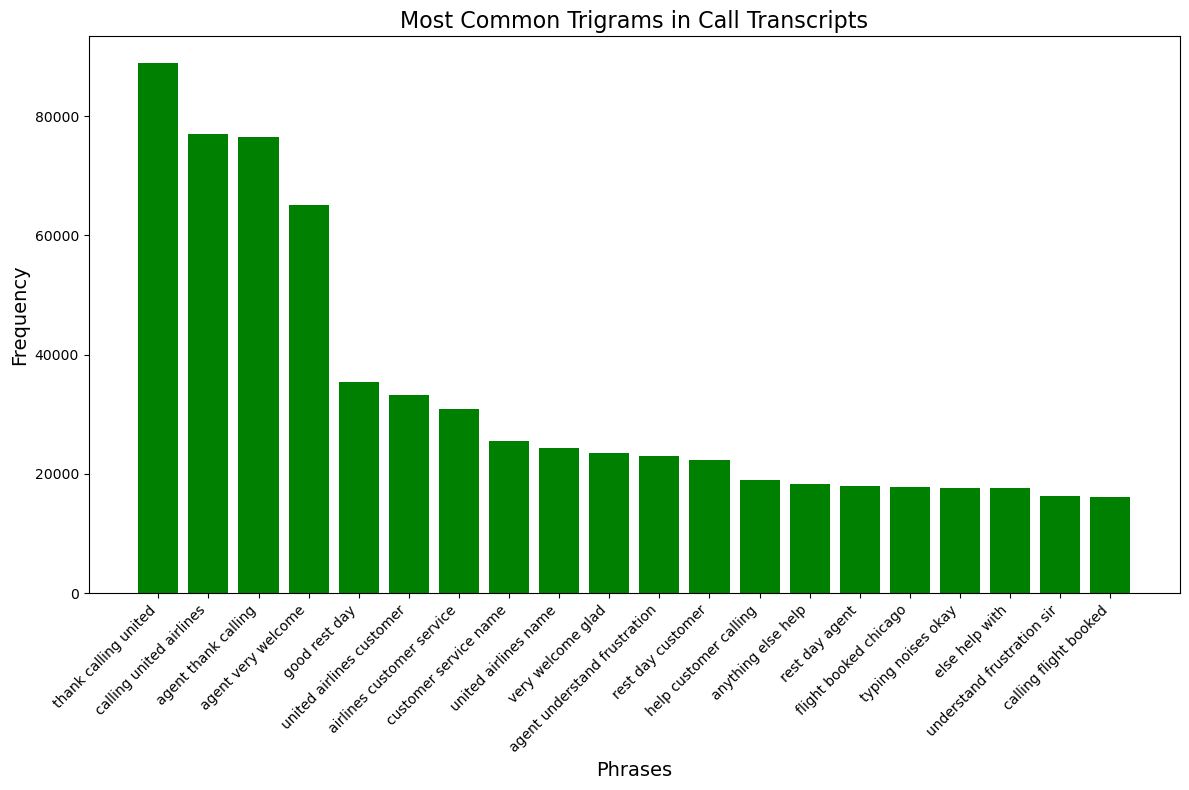

In [32]:
plot_word_frequencies(trigrams, "Most Common Trigrams in Call Transcripts")

In [33]:
# Step 8: Analyze Call Reasons and Associate with Common Words
# Initialize a dictionary to hold word counts per call reason
reason_word_counts = {}

for reason in merged_df['primary_call_reason'].unique():
    # Filter transcripts by call reason
    filtered_transcripts = merged_df[merged_df['primary_call_reason'] == reason]['call_transcript']

    # Initialize a Counter for the current reason
    current_counter = Counter()

    for transcript in filtered_transcripts:
        tokens = clean_and_tokenize(transcript)
        current_counter.update(tokens)

    # Store the top 20 words for the current reason
    reason_word_counts[reason] = current_counter.most_common(20)

# Display per reason analysis
for reason, words in reason_word_counts.items():
    print(f"\nTop Common Words Associated with Call Reason '{reason}':")
    print(words)



Top Common Words Associated with Call Reason 'Voluntary Cancel':
[('flight', 13966), ('agent', 12455), ('customer', 12305), ('change', 5307), ('with', 5029), ('in', 4494), ('help', 4487), ('thank', 4134), ('united', 3924), ('calling', 3607), ('typing', 3271), ('next', 3209), ('okay', 3112), ('work', 3005), ('day', 2948), ('take', 2924), ('need', 2821), ('thanks', 2656), ('really', 2650), ('know', 2608)]

Top Common Words Associated with Call Reason 'Booking':
[('flight', 23319), ('agent', 20399), ('customer', 19803), ('change', 9488), ('with', 8288), ('help', 7197), ('in', 7122), ('thank', 6825), ('united', 6142), ('calling', 5985), ('typing', 5339), ('next', 5214), ('okay', 5178), ('day', 4983), ('work', 4967), ('take', 4785), ('need', 4628), ('thanks', 4294), ('really', 4276), ('know', 4228)]

Top Common Words Associated with Call Reason 'IRROPS':
[('flight', 114991), ('agent', 102562), ('customer', 101972), ('change', 46024), ('with', 42325), ('help', 37651), ('in', 37458), ('thank

In [34]:
# Step 9: Propose IVR Improvements Based on Analysis
def suggest_ivr_improvements(word_counts, bigrams, trigrams):
    """
    Suggests IVR improvements based on the frequency of specific keywords and phrases.
    """
    ivr_suggestions = []

    # Flight Management
    if any(word in word_counts for word in ['cancel', 'flight', 'status', 'change']):
        ivr_suggestions.append(
            "Add 'Flight Management' options: "
            "Press 1 to Cancel Flight, Press 2 to Change Flight, Press 3 to Check Flight Status."
        )

    # Billing and Payments
    if any(word in word_counts for word in ['bill', 'refund', 'invoice', 'payment']):
        ivr_suggestions.append(
            "Add 'Billing & Payment' options: "
            "Press 4 to Report Billing Errors, Press 5 to Request a Refund, Press 6 to View Invoice Details."
        )

    # Account Management
    if any(word in word_counts for word in ['password', 'account', 'reset', 'unlock']):
        ivr_suggestions.append(
            "Add 'Account Management' options: "
            "Press 7 to Reset Password, Press 8 to Unlock Account, Press 9 for Account Access Issues."
        )

    # Technical Support
    if any(word in word_counts for word in ['app', 'website', 'technical', 'support', 'issue']):
        ivr_suggestions.append(
            "Add 'Technical Support' options: "
            "Press 10 for App Issues, Press 11 for Website Issues, Press 12 for Connectivity Problems."
        )

    # General Information and FAQs
    if any(word in word_counts for word in ['info', 'faq', 'question', 'how']):
        ivr_suggestions.append(
            "Add 'General Information' options: "
            "Press 13 for Frequently Asked Questions (FAQ), Press 14 to Learn How to Use Our Services."
        )

    # Feedback Mechanism
    ivr_suggestions.append(
        "Add 'Feedback' option: "
        "Press 15 to Provide Feedback on Your Call Experience."
    )

    # Additional Suggestions Based on Bigrams and Trigrams
    # Example: If 'track my order' is a common trigram
    if trigrams[('track', 'my', 'order')] > 5000:
        ivr_suggestions.append(
            "Add 'Order Tracking' option: "
            "Press 16 to Track Your Order Status."
        )

    # Example: If 'reset password' is a common bigram
    if bigrams[('reset', 'password')] > 4000:
        ivr_suggestions.append(
            "Enhance 'Password Reset' functionality to allow users to reset passwords directly through the IVR."
        )

    return ivr_suggestions

# Generate IVR improvement suggestions based on the analysis
ivr_improvements = suggest_ivr_improvements(word_counts, bigrams, trigrams)


In [35]:
# Display IVR suggestions
print("\nSuggested IVR Improvements:")
for suggestion in ivr_improvements:
    print(f"- {suggestion}")

# Step 10: Additional Recommendations (More Suggestions)
# Based on further analysis, you can add more specific suggestions
additional_suggestions = [
    "Implement 'Self-Service Account Updates': Allow customers to update their personal information via IVR.",
    "Introduce 'Loyalty Program Management': Press 17 to Manage Your Loyalty Program Benefits.",
    "Add 'Travel Insurance': Press 18 to Inquire About or Purchase Travel Insurance.",
    "Create 'Emergency Assistance' options: Press 19 for Immediate Assistance in Case of Emergencies.",
    "Provide 'Visa and Documentation' support: Press 20 for Help with Visa Applications and Required Documentation."
]

# Append additional suggestions to IVR improvements
ivr_improvements.extend(additional_suggestions)

# Display all IVR suggestions including additional ones
print("\nComprehensive IVR Improvement Suggestions:")
for suggestion in ivr_improvements:
    print(f"- {suggestion}")



Suggested IVR Improvements:
- Add 'Flight Management' options: Press 1 to Cancel Flight, Press 2 to Change Flight, Press 3 to Check Flight Status.
- Add 'Billing & Payment' options: Press 4 to Report Billing Errors, Press 5 to Request a Refund, Press 6 to View Invoice Details.
- Add 'Account Management' options: Press 7 to Reset Password, Press 8 to Unlock Account, Press 9 for Account Access Issues.
- Add 'Technical Support' options: Press 10 for App Issues, Press 11 for Website Issues, Press 12 for Connectivity Problems.
- Add 'General Information' options: Press 13 for Frequently Asked Questions (FAQ), Press 14 to Learn How to Use Our Services.
- Add 'Feedback' option: Press 15 to Provide Feedback on Your Call Experience.

Comprehensive IVR Improvement Suggestions:
- Add 'Flight Management' options: Press 1 to Cancel Flight, Press 2 to Change Flight, Press 3 to Check Flight Status.
- Add 'Billing & Payment' options: Press 4 to Report Billing Errors, Press 5 to Request a Refund, Pres

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Step 1: Load the datasets
calls_df = pd.read_csv('calls.csv')
customers_df = pd.read_csv('customers.csv')
reasons_df = pd.read_csv('reason.csv')
sentiment_statistics_df = pd.read_csv('sentiment_statistics.csv')
# test_data = pd.read_csv('test.csv')

# Step 2: Data Cleaning (removing rows with null values)
calls_df.dropna(inplace=True)
reasons_df.dropna(inplace=True)
sentiment_statistics_df.dropna(inplace=True)

In [37]:
import pandas as pd
import re

# Function to clean spaces
def clean_spaces(text):
    if isinstance(text, str):
        # Remove leading and trailing spaces
        text = text.strip()
        # Replace multiple spaces with a single space
        text = re.sub(r'\s+', ' ', text)
    return text

# Apply the cleaning function to the primary_call_reason column
reasons_df['primary_call_reason'] = reasons_df['primary_call_reason'].apply(clean_spaces)

# Mapping dictionary for similar phrases
mapping = {
    'Post Flight': 'Post-Flight',
    'Products & Services': 'Products and Services',
    'Check In': 'Check-In'
}

# Replace similar reasons using the mapping
reasons_df['primary_call_reason'] = reasons_df['primary_call_reason'].replace(mapping)

# Display the cleaned reasons
print("Cleaned Primary Call Reasons:")
print(reasons_df)

Cleaned Primary Call Reasons:
          call_id primary_call_reason
0      4667960400    Voluntary Cancel
1      1122072124             Booking
2      6834291559              IRROPS
3      2266439882             Upgrade
4      1211603231             Seating
...           ...                 ...
66648  7569738090        Mileage Plus
66649  1563273072         Post-Flight
66650  8865997781             Upgrade
66651  8019240181             Upgrade
66652  8210720833     Digital Support

[66653 rows x 2 columns]


In [ ]:
# Step 3: Merge datasets (on 'call_id' and other keys)
merged_data = pd.merge(calls_df, reasons_df, on='call_id')
merged_data = pd.merge(merged_data, sentiment_statistics_df, on='call_id')
merged_data = pd.merge(merged_data, customers_df, on='customer_id')

# Step 4: Further Data Cleaning for merged dataset
merged_data.dropna(subset=['primary_call_reason', 'call_transcript'], inplace=True)

# Step 5: Feature Engineering
merged_data['call_start_datetime'] = pd.to_datetime(merged_data['call_start_datetime'])
merged_data['call_end_datetime'] = pd.to_datetime(merged_data['call_end_datetime'])
merged_data['call_duration'] = (merged_data['call_end_datetime'] - merged_data['call_start_datetime']).dt.total_seconds()

merged_data['call_hour'] = merged_data['call_start_datetime'].dt.hour

def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

merged_data['time_of_day'] = merged_data['call_hour'].apply(get_time_of_day)

# Step 6: Label Encoding for categorical features
label_encoder = LabelEncoder()

# Encoding 'customer_tone', 'agent_tone', 'time_of_day'
merged_data['customer_tone_encoded'] = label_encoder.fit_transform(merged_data['customer_tone'])
merged_data['agent_tone_encoded'] = label_encoder.fit_transform(merged_data['agent_tone'])
merged_data['time_of_day_encoded'] = label_encoder.fit_transform(merged_data['time_of_day'])

# Step 7: Text Analysis (using TF-IDF for call transcripts)
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
transcript_tfidf = tfidf.fit_transform(merged_data['call_transcript'])

transcript_df = pd.DataFrame(transcript_tfidf.toarray(), columns=tfidf.get_feature_names_out())
merged_data = pd.concat([merged_data, transcript_df], axis=1)

# Step 8: Model Training and Predictive Analysis
features = ['call_duration', 'silence_percent_average', 'customer_tone_encoded', 'agent_tone_encoded','elite_level_code','average_sentiment',] + list(transcript_df.columns)

# Fill any missing values in numerical columns with 0 (as a fallback step for model compatibility)
merged_data[features] = merged_data[features].fillna(0)

X = merged_data[features]
y = merged_data['primary_call_reason']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Step 9: Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
# For Test.csv File

In [ ]:
#importing libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier


In [ ]:
# Step 1: Load all necessary datasets
test_data = pd.read_csv('test.csv')  # test.csv only contains call_id
calls_data = pd.read_csv('calls.csv')  # Contains call-related features
customers_data = pd.read_csv('customers.csv')  # Contains customer-related features
reasons_data = pd.read_csv('reason.csv')  # Contains primary_call_reason
sentiment_data = pd.read_csv('sentiment_statistics.csv')  # Sentiment related features

# Step 2: Merge test data with other datasets using `call_id` (join on call_id)
# This assumes each call_id in the test file exists in calls_data, customers_data, etc.
test_data = test_data.merge(calls_data, on='call_id', how='left')
test_data = test_data.merge(customers_data, on='customer_id', how='left')
test_data = test_data.merge(sentiment_data, on='call_id', how='left')

# Step 3: Feature Engineering (same as training data)
test_data['call_start_datetime'] = pd.to_datetime(test_data['call_start_datetime'])
test_data['call_end_datetime'] = pd.to_datetime(test_data['call_end_datetime'])

# Calculate call_duration
test_data['call_duration'] = (test_data['call_end_datetime'] - test_data['call_start_datetime']).dt.total_seconds()

# Creating call_hour and time_of_day features
test_data['call_hour'] = test_data['call_start_datetime'].dt.hour


In [ ]:
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

test_data['time_of_day'] = test_data['call_hour'].apply(get_time_of_day)


In [ ]:
# Step 4: Label Encoding for categorical columns ('customer_tone', 'agent_tone', 'time_of_day')
label_encoder = LabelEncoder()
test_data['customer_tone_encoded'] = label_encoder.fit_transform(test_data['customer_tone'].fillna(''))
test_data['agent_tone_encoded'] = label_encoder.fit_transform(test_data['agent_tone'].fillna(''))
test_data['time_of_day_encoded'] = label_encoder.fit_transform(test_data['time_of_day'].fillna(''))

# Step 5: TF-IDF transformation for the call transcript
# Use the same TF-IDF vectorizer that was fitted on training data
tfidf = TfidfVectorizer(max_features=100, stop_words='english')

# For this example, you'd fit the vectorizer using training data (recreate or load the vectorizer)
train_transcripts = merged_data['call_transcript'].fillna('')
tfidf.fit(train_transcripts)

# Transform the test transcripts using the same TF-IDF vectorizer
test_transcript_tfidf = tfidf.transform(test_data['call_transcript'].fillna(''))
test_transcript_df = pd.DataFrame(test_transcript_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Step 6: Concatenate the test TF-IDF features with the original test DataFrame
test_data = pd.concat([test_data, test_transcript_df], axis=1)

# Step 7: Ensure that the test dataset contains the same features as the training set
features = ['call_duration', 'silence_percent_average', 'customer_tone_encoded', 'agent_tone_encoded','elite_level_code','average_sentiment',] + list(transcript_df.columns)

# Since test_data doesn't have some of these features, you can fill them with defaults (e.g., 0)
test_data['silence_percent_average'] = test_data['silence_percent_average'].fillna(0)

# Ensure no NaNs in the features columns
test_data[features] = test_data[features].fillna(0)

# Predict the primary call reason for test data
test_predictions = model.predict(test_data[features])

# Step 9: Save the predictions in the required format
output = pd.DataFrame({'call_id': test_data['call_id'], 'primary_call_reason': test_predictions})

In [ ]:
# Save to CSV
output.to_csv('TESTTTT.csv', index=False)